In [34]:
#ALGORITHM = 'Neural Network'
ALGORITHM = 'Neural Network [TYPE]'
ALGORITHM_DETAIL = ''
ALGORITHM_DETAIL_ORIG = ALGORITHM_DETAIL
#ALGORITHM_DETAIL += ' tbc'
DATA_DETAIL = []
#DATA_DETAIL = ['no scale','no dummies']
VERSION = '09'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

#selected_neural_network='simplest'
#selected_neural_network='quite simple'
#selected_neural_network='recommended simple v2'
#selected_neural_network='adapted v3'


# ---- FIRST NEURAL NETWORK STRUCTURE DEFINITION ---- # 
#selected_neural_network = 'recommended simple v1'
#selected_nn_code = 'm01 simple'

# ---- 2nd NEURAL NETWORK STRUCTURE DEFINITION ---- # 
#selected_neural_network = selected_nn_code = "m02 two layers"


# ---- 3rd NEURAL NETWORK STRUCTURE DEFINITION ---- # 
#selected_neural_network = selected_nn_code = "m03 2 layers+wider"


# ---- 4th NEURAL NETWORK STRUCTURE DEFINITION ---- # 
selected_neural_network = selected_nn_code = "m04 3 layers+wider"

# ---- 5th NEURAL NETWORK STRUCTURE DEFINITION ---- # 
#selected_neural_network = selected_nn_code = "m05 rec deep"

# ---- 6th NEURAL NETWORK STRUCTURE DEFINITION ---- # 
#selected_neural_network = selected_nn_code = "m05 my deep"

#selected_neural_network = selected_nn_code = ""
selected_neural_network = selected_nn_code = "m11 mega"
selected_neural_network = selected_nn_code = "m12 mega"


ALGORITHM = ALGORITHM.replace("[TYPE]", selected_nn_code)

In [35]:
#! pip install scikeras
#! pip install catboost

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from scikeras.wrappers import KerasClassifier, KerasRegressor

import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

print("Tensorflow version:", tf.__version__)

loss_dict = {"mean_squared_error":'mse'}

def make_simple_ann(key, inputs=-1):
    if False:
        pass
    elif key == 'quite simple':

        new_algorithm_detail = ALGORITHM_DETAIL_ORIG + 'quite simple model + normalise, mse'

        learn_rate = 0.1
        epochs, chosen_loss = 100, 'mean_squared_error'
        
        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))

        chosen_model = tf.keras.Sequential([
            layers.Dense(11, input_shape=(len(X_train[0]),), activation='relu'),
            normalizer,
            layers.Dense(units=1)
        ])

    elif key == 'recommended simple v1':

        learn_rate = 0.003 #0.3
        epochs, chosen_loss = 50, 'mean_squared_error'
        
        new_algorithm_detail = ALGORITHM_DETAIL_ORIG + 'recommended simple model/mse'

        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))

        chosen_model = tf.keras.Sequential([
            layers.Dense(11, input_shape=(len(X_train[0]),), activation='relu'),
            normalizer,
            layers.Dense(units=1)
        ])

    elif key == 'm02 two layers':

        learn_rate = 0.003 #0.3
        epochs, chosen_loss = 500, 'mean_squared_error'

        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))

        chosen_model = tf.keras.Sequential([
            layers.Dense(11, input_shape=(len(X_train[0]),), activation='relu'),
            normalizer,
            layers.Dense(11, activation='relu'),
            layers.Dense(units=1)
        ])

        
    elif key == 'm03 2 layers+wider':

        learn_rate = 0.0003 # 0.003 #0.3
        epochs, chosen_loss = 500, 'mean_squared_error'
        
        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))

        chosen_model = tf.keras.Sequential([
            layers.Dense(11, input_shape=(len(X_train[0]),), activation='relu'),
            normalizer,
            layers.Dense(30, activation='relu'),
            layers.Dense(units=1)
        ])

    elif key == 'm04 3 layers+wider':

        learn_rate = 0.003
        epochs, chosen_loss = 500, 'mean_squared_error'

        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))

        chosen_model = tf.keras.Sequential([
            layers.Dense(11, input_shape=(len(X_train[0]),), activation='relu'),
            normalizer,
            layers.Dense(30, activation='relu'),
            layers.Dense(40, activation='relu'),
            layers.Dense(units=1)
        ])

    elif key == 'm0x four layers,wider,batchnorm':

        learn_rate = 0.0003 #0.3
        epochs, chosen_loss = 500, 'mean_squared_error'
        
        #from layers.normalization import BatchNormalization
        
        normalizer = tf.keras.layers.Normalization(axis=-1)
        batchnorm = layers.BatchNormalization()
        activation = layers.Activation('relu')
        
        normalizer.adapt(np.array(X_train))
        new_algorithm_detail += ' +norm'

        chosen_model = tf.keras.Sequential([
            layers.Dense(11, input_shape=(len(X_train[0]),), activation='relu'),
            #normalizer,
            layers.Dense(30, activation='relu'),
            batchnorm,
            activation,
            layers.Dense(40, activation='relu'),
            layers.Dense(30, activation='relu'),
            layers.Dense(units=1)
        ])

    elif key == 'm05 rec deep':
        chosen_model = Sequential()

        # The Input Layer :
        chosen_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

        # The Hidden Layers :
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

        # The Output Layer :
        chosen_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

        # Compile the network :
        #chosen_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

        learn_rate = 0.0003 #0.3
        epochs, chosen_loss = 500, 'mean_squared_error'

    elif key == 'm11 mega':
        chosen_model = Sequential()

        # The Input Layer :
        chosen_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

        # The Hidden Layers :
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(2148, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(2148, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

        # The Output Layer :
        chosen_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

        # Compile the network :
        #chosen_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

        learn_rate = 0.0003
        epochs, chosen_loss = 400, 'mean_squared_error'

    elif key == 'm12 mega':
        chosen_model = Sequential()

        # The Input Layer :
        chosen_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

        # The Hidden Layers :
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

        # The Output Layer :
        chosen_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

        # Compile the network :
        #chosen_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

        learn_rate = 0.0003
        epochs, chosen_loss = 400, 'mean_squared_error'

    else:
        raise ValueError("make_simple_ann: no entry for key:", key)

    if run_env == 'local':
        epochs = 5

    chosen_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate),
        loss=chosen_loss)


    new_algorithm_detail = ALGORITHM_DETAIL_ORIG + loss_dict[chosen_loss]
    new_algorithm_detail += f' +epochs={epochs}'
    new_algorithm_detail += f' +learn={learn_rate}'
    
    return chosen_model, new_algorithm_detail, epochs, {'learning_rate':learn_rate}

#make_simple_ann('m04 four layers,wider,batchnorm')

Tensorflow version: 2.9.1


In [37]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)

no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
not_catboost = True

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_0__common_20221116 import get_columns
    from functions_b__get_the_data_20221116 import set_csv_directory, get_combined_dataset
    from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
    from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
    from functions_d3__prepare_store_data_20221116 import create_train_test_data
    from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
    from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results

    set_csv_directory('final_split')

    quick_mode = True
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_0__common_20221116 import get_columns
    from functions_b__get_the_data_20221116 import set_csv_directory, get_combined_dataset
    from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
    from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
    from functions_d3__prepare_store_data_20221116 import create_train_test_data
    from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
    from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results


{'notebook_environment': 'gradient', 'use_gpu': True, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [38]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [39]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [40]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v09.csv
(46871, 19)


In [41]:
df['Price'] = df['Price'] / 1000
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType,feature__balcony,feature__chain free,feature__no onward chain,feature__off street parking,feature__one bedroom,feature__private balcony,feature__share of freehold,feature__three bedrooms,feature__two bedrooms,feature__two double bedrooms
14520525,550.000,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD,0,0,0,0,0,1,0,0,0,0
27953107,400.000,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD,1,0,0,0,0,0,0,0,0,1
33593487,579.950,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD,0,0,1,0,0,0,0,0,0,0
35271294,370.000,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD,1,0,0,0,0,0,0,0,0,0
35429088,599.950,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN,0,0,0,0,0,0,0,0,0,0
44749111,475.000,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD,0,0,0,0,0,0,0,0,0,0
46204665,435.000,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD,0,0,0,0,0,0,0,1,0,0
49020666,200.000,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD,0,0,0,0,1,0,0,0,0,0
49036279,275.000,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD,0,0,0,0,0,0,0,0,0,0
49303873,450.000,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD,0,0,0,0,0,0,0,0,0,0


In [42]:
df.isnull().sum()

Price                              0
bedrooms                           0
bathrooms                          0
nearestStation                     0
location.latitude                  0
location.longitude                 0
latitude_deviation                 0
longitude_deviation                0
tenure.tenureType               2744
feature__balcony                   0
feature__chain free                0
feature__no onward chain           0
feature__off street parking        0
feature__one bedroom               0
feature__private balcony           0
feature__share of freehold         0
feature__three bedrooms            0
feature__two bedrooms              0
feature__two double bedrooms       0
dtype: int64

In [43]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Price                         46871 non-null  float64
 1   bedrooms                      46871 non-null  float64
 2   bathrooms                     46871 non-null  float64
 3   nearestStation                46871 non-null  float64
 4   location.latitude             46871 non-null  float64
 5   location.longitude            46871 non-null  float64
 6   latitude_deviation            46871 non-null  float64
 7   longitude_deviation           46871 non-null  float64
 8   tenure.tenureType             44127 non-null  object 
 9   feature__balcony              46871 non-null  int64  
 10  feature__chain free           46871 non-null  int64  
 11  feature__no onward chain      46871 non-null  int64  
 12  feature__off street parking   46871 non-null  int

,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425.069391,107.227325,100.000000,349.950000,425.000000,515.000000,600.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895
feature__balcony,46871.0,0.038617,0.193124,0.000000,0.000000,0.000000,0.000000,2.000000
feature__chain free,46871.0,0.120266,0.325800,0.000000,0.000000,0.000000,0.000000,2.000000


In [44]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425.069391,107.227325,100.000000,349.950000,425.000000,515.000000,600.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895
feature__balcony,46871.0,0.038617,0.193124,0.000000,0.000000,0.000000,0.000000,2.000000
feature__chain free,46871.0,0.120266,0.325800,0.000000,0.000000,0.000000,0.000000,2.000000


In [45]:
df.isna().sum()

Price                              0
bedrooms                           0
bathrooms                          0
nearestStation                     0
location.latitude                  0
location.longitude                 0
latitude_deviation                 0
longitude_deviation                0
tenure.tenureType               2744
feature__balcony                   0
feature__chain free                0
feature__no onward chain           0
feature__off street parking        0
feature__one bedroom               0
feature__private balcony           0
feature__share of freehold         0
feature__three bedrooms            0
feature__two bedrooms              0
feature__two double bedrooms       0
dtype: int64

In [46]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,feature__balcony,feature__chain free,feature__no onward chain,feature__off street parking,feature__one bedroom,feature__private balcony,feature__share of freehold,feature__three bedrooms,feature__two bedrooms,feature__two double bedrooms
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425.224642,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699,0.038865,0.121218,0.058898,0.047001,0.041834,0.040111,0.048428,0.059374,0.072586,0.096857
std,107.203333,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220,0.193744,0.326940,0.235437,0.212071,0.200211,0.196338,0.214989,0.236326,0.259459,0.295919
min,100.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,349.950000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,425.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,515.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,600.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000


In [47]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)


(39714, 21) (4413, 21) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [48]:
trainable_model, ALGORITHM_DETAIL, chosen_epochs, chosen_params = make_simple_ann(selected_neural_network)

ALGORITHM_DETAIL

'mse +epochs=400 +learn=0.0003'

In [49]:
trainable_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               2816      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 512)               131584    
                                                                 
 dense_11 (Dense)            (None, 1024)              525312    
                                                                 
 dense_12 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 dense_14 (Dense)            (None, 256)              

In [50]:
callback_x1 = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# https://keras.io/api/callbacks/early_stopping/
callback_x2 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)



In [ ]:
val_split = 0.1

callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss", #"val_loss",
    min_delta=10, #50,
    patience=10,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True # False,
)

pipe_start = time()

'''history = trainable_model.fit(
    X_train, 
    y_train, 
    #batch_size=batch_size, 
    epochs=chosen_epochs, 
    validation_split=0.05 #validation_split,
    callbacks= [
        keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='min'), 
        keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    ], 
    class_weight=class_weights)'''


history = trainable_model.fit(
    X_train,
    y_train,
    epochs=chosen_epochs,
    # verbose=0 to suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split=val_split,  #0.2,
    callbacks=[callback],
)
pipe_end = time()
estimated_time = round((pipe_end - pipe_start), 2)

Epoch 1/400
1117/1117 [==============================] - 5s 4ms/step - loss: 4942.7793 - val_loss: 4968.6406
Epoch 2/400
1117/1117 [==============================] - 5s 5ms/step - loss: 4914.8486 - val_loss: 4794.8213
Epoch 3/400
1117/1117 [==============================] - 5s 5ms/step - loss: 4920.4829 - val_loss: 4943.5859
Epoch 4/400
1117/1117 [==============================] - 5s 5ms/step - loss: 4915.2871 - val_loss: 4798.3848
Epoch 5/400
1117/1117 [==============================] - 5s 4ms/step - loss: 4883.6963 - val_loss: 4786.8877
Epoch 6/400
1117/1117 [==============================] - 5s 4ms/step - loss: 4898.0786 - val_loss: 4854.3447
Epoch 7/400
1117/1117 [==============================] - 5s 4ms/step - loss: 4898.2949 - val_loss: 4801.7490
Epoch 8/400
1117/1117 [==============================] - 5s 4ms/step - loss: 4896.8296 - val_loss: 5070.9336
Epoch 9/400
1117/1117 [==============================] - 6s 6ms/step - loss: 4867.4951 - val_loss: 4882.5352
Epoch 10/400
1117/1

In [52]:
#ALGORITHM_DETAIL.replace("epochs=", f"epochs={len(hist)}/")

In [53]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

early_end_lossX = hist.iloc[-1]['loss']
early_end_loss = hist['loss'].min()
early_end_valloss = hist['val_loss'].min()

more_detail = f"loss={round(early_end_loss,2)} valloss={round(early_end_valloss,2)}"
more_detail += f' +valsplit={val_split}'

if len(hist) != chosen_epochs:
    print(f'stopped at {len(hist)}, loss={round(early_end_loss,2)} valloss={round(early_end_valloss,2)}')
    #ALGORITHM_DETAIL += f" +stop={len(hist)}"
    more_detail += f" stop={len(hist)}/{chosen_epochs} "
    #more_detail += ALGORITHM_DETAIL.replace("epochs=", f"epochs={len(hist)}/")
print(more_detail)
print(ALGORITHM_DETAIL)
    
hist.tail()

stopped at 83, loss=4869.67 valloss=4726.34
loss=4869.67 valloss=4726.34 +valsplit=0.1 stop=83/400 
mse +epochs=400 +learn=0.0003


,loss,val_loss,epoch
78,4887.286133,4913.942871,78
79,4869.666016,4906.981445,79
80,4874.992676,5211.087402,80
81,4894.154297,4800.118652,81
82,4875.768066,4726.335938,82


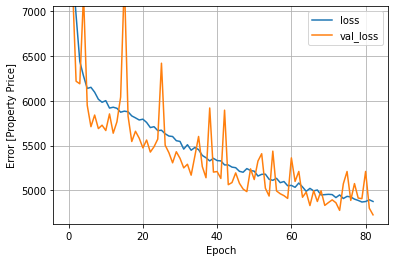

In [54]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    min_y = min(min(history.history['val_loss']),min(history.history['loss'])) - 100
    #max_y = min(max(history.history['val_loss']),max(history.history['loss'])) + 500
    max_y = min(sorted(history.history['val_loss'])[-3],sorted(history.history['loss'])[-3]) + 100
    plt.ylim([min_y, max_y])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Property Price]')
    plt.legend()
    plt.grid(True)


plot_loss(history)

In [55]:
y_pred = trainable_model.predict(X_test)

138/138 [==============================] - 0s 2ms/step


In [56]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Neural Network m12 mega----------
R square Accuracy 0.5703345468751653
Mean Absolute Error Accuracy 55.158283239997814
Mean Squared Error Accuracy 4853.6752431847635
Root Mean Squared Error 69.66832309726396


In [57]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [58]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400.00,382.676178,17.323822,4.330956,4.527019
119328242,369.95,408.607147,38.657147,10.449290,9.460712
125716790,350.00,357.661072,7.661072,2.188878,2.141992
122440040,549.00,497.319885,51.680115,9.413500,10.391725
120508103,495.00,479.550659,15.449341,3.121079,3.221629
...,...,...,...,...,...
68620869,475.00,546.638550,71.638550,15.081800,13.105287
85735665,575.00,561.967224,13.032776,2.266570,2.319135
125706338,400.00,435.713501,35.713501,8.928375,8.196556


In [59]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122265818,160,521,361.845947,226.153717,69.339611,160,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
109722224,108,337,229.946533,212.913457,68.042282,108,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
85667184,122,354,232.783936,190.806505,65.612874,122,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
83639617,190,462,272.537140,143.440600,58.922218,190,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
123427112,175,369,194.633331,111.219046,52.655785,175,1,1,0.069943,51.501222,0.060959,0.001502,0.165379,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123666536,450,450,0.085907,0.019090,0.019087,450,4,1,0.316823,51.582457,-0.324375,0.082737,0.219955,LEASEHOLD
122360327,400,400,0.071869,0.017967,0.017964,400,1,1,0.361680,51.511643,-0.248861,0.011923,0.144441,LEASEHOLD
123916022,450,450,0.047516,0.010559,0.010558,450,3,2,1.471989,51.589280,0.157530,0.089560,0.261950,FREEHOLD
121057802,299,298,0.028595,0.009564,0.009564,299,2,1,0.215882,51.378988,-0.078173,0.120732,0.026247,LEASEHOLD


138/138 [==============================] - 0s 1ms/step


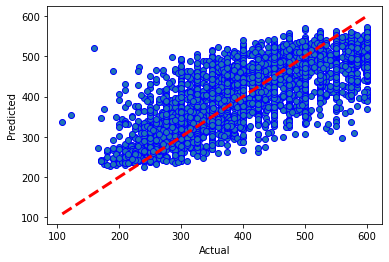

In [60]:
fig, ax = plt.subplots()
#ax.scatter(y_test, best_estimator_pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.scatter(y_test, trainable_model.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [61]:
#cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"] if not_catboost else 999
#cv_best_model_fit_time = 999
cv_best_model_fit_time = estimated_time

DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} (v{VERSION})'.lower()

method = f"{ALGORITHM_DETAIL}{DD2}"

new_results = {
    #'_score': score,
    '_score': R2,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    #'_params': crossval_runner.best_params_ if not_catboost else cat_params,
    #'_params': 'not available', # REPLACED - can't have different models all saying params not available
    '_params': ALGORITHM_DETAIL,
    '_method': more_detail, #ALGORITHM_DETAIL,
    'run_env': run_env
}

if run_env not in ['colab']:
    old_results_json = get_results()
    try:
        old_best_score = old_results_json[key]['best score']
    except:
        print(f"haven't scored this model yet: {ALGORITHM}")
        old_best_score = -999
    this_model_is_best = update_results(old_results_json, new_results, key)

print(key)
print(ALGORITHM_DETAIL)

neural network m12 mega (v09)
mse +epochs=400 +learn=0.0003


In [62]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        #        if not_catboost:
        #            pickle.dump(crossval_runner.best_estimator_, f)
        #        else:
        #            pickle.dump(starter_model, f)
        pickle.dump(trainable_model, f)
        print('pickled new version of model')
        print(f"{old_results_json[key]['_score']} is new best score (it's better than {old_best_score})")
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    print("not updated saved model, the previous run was better")
    print(old_results_json[key]['_score'], 'is worse than or equal to', old_best_score)


INFO:tensorflow:Assets written to: ram://512bcca9-e6f1-4c15-97c1-9179069d01af/assets
pickled new version of model
0.5703345468751653 is new best score (it's better than 0.526171003581366)


In [63]:
# # OLD CODE
# if False:
#     def make_regression_ann(key, initializer='uniform', activation='relu', optimizer='adam', loss='mse'):
#         normalizer = tf.keras.layers.Normalization(axis=-1)
#         model = Sequential()
#         #model.add(normalizer)
#         model.add(Dense(11, input_shape=(len(X_train[0]),), activation='relu'))
#         model.add(Dense(20, activation='relu'))
#         model.add(Dense(500, activation='relu'))
#         model.add(Dense(500, activation='relu'))
#         model.add(Dense(20, activation='relu'))
#         model.add(Dense(5, activation='relu'))
#         model.add(Dense(1))
#         model.compile(loss=loss, optimizer=optimizer)
#         #print(model)
#     
#         description = '[input11, d^20-500-500-20-5, dense1]'
#         return model, description


In [64]:
# OLD CODE

# def make_simple_ann(key, inputs=-1):
#     if key == 'simplest':
#         new_algorithm_detail = ALGORITHM_DETAIL_ORIG + 'simplest findable model + normalise, MSE loss'

#         learn_rate = 0.1
#         epochs = 100
        
#         normalizer = tf.keras.layers.Normalization(axis=-1)
#         normalizer.adapt(np.array(X_train))

#         chosen_model = tf.keras.Sequential([
#             normalizer,
#             layers.Dense(units=1)
#         ])

#         chosen_model.compile(
#             optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate),
#             loss='mean_squared_error')


#     elif key == 'quite simple':

#         new_algorithm_detail = ALGORITHM_DETAIL_ORIG + 'quite simple model + normalise, mse'

#         learn_rate = 0.1
#         epochs = 100
        
#         normalizer = tf.keras.layers.Normalization(axis=-1)
#         normalizer.adapt(np.array(X_train))

#         chosen_model = tf.keras.Sequential([
#             layers.Dense(11, input_shape=(len(X_train[0]),), activation='relu'),
#             normalizer,
#             layers.Dense(units=1)
#         ])

#         chosen_model.compile(
#             optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate),
#             loss='mean_squared_error')

#     elif key == 'recommended simple v1':

#         learn_rate = 0.3
#         epochs = 300
        
#         new_algorithm_detail = ALGORITHM_DETAIL_ORIG + 'recommended simple model/mse'

#         normalizer = tf.keras.layers.Normalization(axis=-1)
#         normalizer.adapt(np.array(X_train))
#         new_algorithm_detail += ' +norm'

#         chosen_model = tf.keras.Sequential([
#             layers.Dense(11, input_shape=(len(X_train[0]),), activation='relu'),
#             normalizer,
#             layers.Dense(units=1)
#         ])

#         chosen_model.compile(
#             #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
#             optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate),
#             loss='mean_squared_error')


#     elif key == 'recommended simple v2':

#         new_algorithm_detail = ALGORITHM_DETAIL_ORIG + 'recommended simple model + normalise, mse'

#         learn_rate = 0.003
#         epochs = 100
                
#         normalizer = tf.keras.layers.Normalization(axis=-1)
#         normalizer.adapt(np.array(X_train))

#         chosen_model = tf.keras.Sequential([
#             layers.Dense(11, input_shape=(len(X_train[0]),), activation='relu'),
#             normalizer,
#             layers.Dense(11, activation='relu'),
#             layers.Dense(11, activation='relu'),
#             layers.Dense(11, activation='relu'),
#             layers.Dense(11, activation='relu'),
#             layers.Dense(11, activation='relu'),
#             layers.Dense(11, activation='relu'),
#             layers.Dense(units=1)
#         ])

#         chosen_model.compile(
#             #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
#             #optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
#             optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate),
#             loss='mean_squared_error')


#     elif key == 'adapted v3':

#         new_algorithm_detail = ALGORITHM_DETAIL_ORIG + 'v3 adapted,normalise,mse'

#         learn_rate = 0.0003
#         epochs = 500
        
#         normalizer = tf.keras.layers.Normalization(axis=-1)
#         normalizer.adapt(np.array(X_train))

#         chosen_model = tf.keras.Sequential([
#             layers.Dense(11, input_shape=(len(X_train[0]),), activation='relu'),
#             normalizer,
#             layers.Dense(50, activation='relu'),
#             layers.Dense(300, activation='relu'),
#             layers.Dense(50, activation='relu'),
#             layers.Dense(11, activation='relu'),
#             layers.Dense(units=1)
#         ])

#         chosen_model.compile(
#             #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
#             #optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
#             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
#             loss='mean_squared_error')


#     # elif key == 'my model':
#     #     ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG  + 'my model (make_regression_ann)'
#     # 
#     #     simple_model = make_regression_ann()
#     #     trainable_model = simple_model
#     #     
#     #     epochs = 100
#     else:
#         raise ValueError("make_simple_ann: no entry for key:", key)

#     if run_env == 'local':
#         epochs = 5

#     new_algorithm_detail += f' +epochs={epochs}'
#     new_algorithm_detail += f' +learn={learn_rate}'
#     return chosen_model, new_algorithm_detail, epochs, {'learning_rate':learn_rate}
                                                        

In [65]:
'''
Notes

Model m1
Model: "sequential_3"

_________________________________________________________________
 Layer (type)                Output Shape              Param #
=================================================================
 dense_6 (Dense)             (None, 11)                132       
 normalization_3 (Normalizat  (None, 11)               23        
 ion)                                                            
 dense_7 (Dense)             (None, 1)                 12        
=================================================================
Total params: 167
Trainable params: 144
Non-trainable params: 23
_________________________________________________________________


Model m2
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 dense_14 (Dense)            (None, 11)                132       
 normalization_6 (Normalizat  (None, 11)               23        
 ion)                                                            
 dense_15 (Dense)            (None, 11)                132       
 dense_16 (Dense)            (None, 1)                 12        
                                                                 
=================================================================
Total params: 299
Trainable params: 276
Non-trainable params: 23
_________________________________________________________________


Model m3
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 dense_17 (Dense)            (None, 11)                132       
                                                                 
 normalization_7 (Normalizat  (None, 11)               23        
 ion)                                                            
                                                                 
 dense_18 (Dense)            (None, 30)                360       
                                                                 
 dense_19 (Dense)            (None, 1)                 31        
                                                                 
=================================================================
Total params: 546
Trainable params: 523
Non-trainable params: 23
_________________________________________________________________
'''

print()